# pl

> Phase Linking

<!-- Phase linking for PTA requires `cupy.optimize` to be implented which is tracked at
https://github.com/rapidsai/raft/pull/923
and https://github.com/cupy/cupy/issues/6112 -->

In [ ]:
#| default_exp cli/pl

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
from matplotlib import pyplot as plt
import zarr
import colorcet
import moraine.cli as mc
from moraine.utils_ import is_cuda_available

In [ ]:
#| export
import logging
import time
import zarr
import numpy as np
from pathlib import Path
import math

import dask
from dask import array as da
from dask import delayed
from dask.distributed import Client, LocalCluster, progress
from moraine.utils_ import is_cuda_available, get_array_module
if is_cuda_available():
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from rmm.allocators.cupy import rmm_cupy_allocator
import moraine as mr
import moraine.cli as mc
from moraine.cli.logging import mc_logger
from moraine.cli import mk_clean_dir, dask_from_zarr, dask_from_zarr_overlap, dask_to_zarr

In [ ]:
#| export
@mc_logger
def emi(
    coh:str, # coherence matrix
    ph:str, # output, wrapped phase
    emi_quality:str, #output, pixel quality
    ref:int=0, # reference image for phase
    chunks:int=None, # # chunk size of output zarr dataset, optional. Default: same as `coh`.
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''Phase linking with EMI estimator.
    '''
    coh_path = coh
    ph_path = ph
    emi_quality_path = emi_quality

    logger = logging.getLogger(__name__)
    coh_zarr = zarr.open(coh_path,mode='r')
    n_image = mr.nimage_from_npair(coh_zarr.shape[-1])
    logger.zarr_info(coh_path,coh_zarr)

    if chunks is None: chunks = coh_zarr.chunks[0] 
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np

    logger.info('starting dask cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        cpu_coh = dask_from_zarr(coh_path, chunks=(chunks, *coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)

        logger.info(f'phase linking with EMI.')
        if cuda:
            coh = cpu_coh.map_blocks(cp.asarray)
        else:
            coh = cpu_coh
        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=-1)

        ph_delayed = np.empty_like(coh_delayed,dtype=object)
        emi_quality_delayed = np.empty_like(coh_delayed,dtype=object)
        emi_delayed = delayed(mr.emi,pure=True,nout=2)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                ph_delayed[idx], emi_quality_delayed[idx] = emi_delayed(coh_delayed[idx])
                ph_delayed[idx] = da.from_delayed(ph_delayed[idx],shape=(coh.blocks[idx].shape[0],n_image),meta=xp.array((),dtype=coh.dtype))
                emi_quality_delayed[idx] = da.from_delayed(emi_quality_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=xp.array((),dtype=xp.float32))

        ph = da.block(ph_delayed[...,None].tolist())
        emi_quality = da.block(emi_quality_delayed.tolist())

        if cuda:
            cpu_ph = ph.map_blocks(cp.asnumpy)
            cpu_emi_quality = emi_quality.map_blocks(cp.asnumpy)
        else:
            cpu_ph = ph; cpu_emi_quality = emi_quality
        logger.info(f'got ph and emi_quality.')
        logger.darr_info('ph', cpu_ph)
        logger.darr_info('emi_quality', cpu_emi_quality)

        logger.info('saving ph and emi_quality.')
        _cpu_ph = dask_to_zarr(cpu_ph,ph_path,chunks=(cpu_ph.chunksize[0],1))
        _cpu_emi_quality = dask_to_zarr(cpu_emi_quality,emi_quality_path,chunks=(cpu_emi_quality.chunksize[0]))

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist([_cpu_ph,_cpu_emi_quality])
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_emi_quality = './pl/ds_can_emi_quality.zarr'
ref = 0

In [ ]:
logger = mc.get_logger()

In [ ]:
%%time
emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref)

2025-09-18 12:47:02 - log_args - INFO - running function: emi
2025-09-18 12:47:02 - log_args - INFO - fetching args:
2025-09-18 12:47:02 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2025-09-18 12:47:02 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2025-09-18 12:47:02 - log_args - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2025-09-18 12:47:02 - log_args - INFO - ref = 0
2025-09-18 12:47:02 - log_args - INFO - chunks = None
2025-09-18 12:47:02 - log_args - INFO - cuda = False
2025-09-18 12:47:02 - log_args - INFO - processes = None
2025-09-18 12:47:02 - log_args - INFO - n_workers = None
2025-09-18 12:47:02 - log_args - INFO - threads_per_worker = None
2025-09-18 12:47:02 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:47:02 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:47:02 - log_args - INFO - fetching args done.
2025-09-18 12:47:02 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-09-18 12:47

In [ ]:
%%time
if is_cuda_available():
    emi(ds_can_coh,ds_can_ph,ds_can_emi_quality,ref=ref,cuda=True)

2025-09-18 12:47:12 - log_args - INFO - running function: emi
2025-09-18 12:47:12 - log_args - INFO - fetching args:
2025-09-18 12:47:12 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2025-09-18 12:47:12 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2025-09-18 12:47:12 - log_args - INFO - emi_quality = './pl/ds_can_emi_quality.zarr'
2025-09-18 12:47:12 - log_args - INFO - ref = 0
2025-09-18 12:47:12 - log_args - INFO - chunks = None
2025-09-18 12:47:12 - log_args - INFO - cuda = True
2025-09-18 12:47:12 - log_args - INFO - processes = None
2025-09-18 12:47:12 - log_args - INFO - n_workers = None
2025-09-18 12:47:12 - log_args - INFO - threads_per_worker = None
2025-09-18 12:47:12 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:47:12 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:47:12 - log_args - INFO - fetching args done.
2025-09-18 12:47:12 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-09-18 12:47:

2025-09-18 12:47:14,455 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:47:14 - emi - INFO - dask cluster started.
2025-09-18 12:47:14 - dask_cluster_info - INFO - dask cluster: LocalCUDACluster(dashboard_link='http://127.0.0.1:8787/status', workers=2, threads=2, memory=256.00 GiB)
2025-09-18 12:47:15 - darr_info - INFO - coh dask array shape, chunksize, dtype: (732727, 136), (100000, 136), complex64
2025-09-18 12:47:15 - emi - INFO - phase linking with EMI.


2025-09-18 12:47:14,939 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:47:15 - emi - INFO - got ph and emi_quality.
2025-09-18 12:47:15 - darr_info - INFO - ph dask array shape, chunksize, dtype: (732727, 17), (100000, 17), complex64
2025-09-18 12:47:15 - darr_info - INFO - emi_quality dask array shape, chunksize, dtype: (732727,), (100000,), float32
2025-09-18 12:47:15 - emi - INFO - saving ph and emi_quality.
2025-09-18 12:47:15 - zarr_info - INFO - ./pl/ds_can_ph.zarr zarray shape, chunks, dtype: (732727, 17), (100000, 1), complex64
2025-09-18 12:47:15 - zarr_info - INFO - ./pl/ds_can_emi_quality.zarr zarray shape, chunks, dtype: (732727,), (100000,), float32
2025-09-18 12:47:15 - emi - INFO - computing graph setted. doing all the computing.
2025-09-18 12:47:18 - emi - INFO - computing finished.leted |  3.2s
2025-09-18 12:47:19 - emi - INFO - dask cluster closed.
CPU times: user 276 ms, sys: 403 ms, total: 680 ms
Wall time: 6.91 s


In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
emi_quality = './pl/emi_quality.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/',mode='r')
mc.pc2ras(ds_can_gix, ds_can_emi_quality,emi_quality,rslc_zarr.shape[:2])

2025-09-18 12:47:19 - log_args - INFO - running function: pc2ras
2025-09-18 12:47:19 - log_args - INFO - fetching args:
2025-09-18 12:47:19 - log_args - INFO - idx = './shp/ds_can_gix.zarr'
2025-09-18 12:47:19 - log_args - INFO - pc = './pl/ds_can_emi_quality.zarr'
2025-09-18 12:47:19 - log_args - INFO - ras = './pl/emi_quality.zarr'
2025-09-18 12:47:19 - log_args - INFO - shape = (2500, 1834)
2025-09-18 12:47:19 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:47:19 - log_args - INFO - processes = False
2025-09-18 12:47:19 - log_args - INFO - n_workers = 1
2025-09-18 12:47:19 - log_args - INFO - threads_per_worker = 1
2025-09-18 12:47:19 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:47:19 - log_args - INFO - fetching args done.
2025-09-18 12:47:19 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-09-18 12:47:19 - pc2ras - INFO - loading gix into memory.
2025-09-18 12:47:19 - pc2ras - INFO - starting dask local

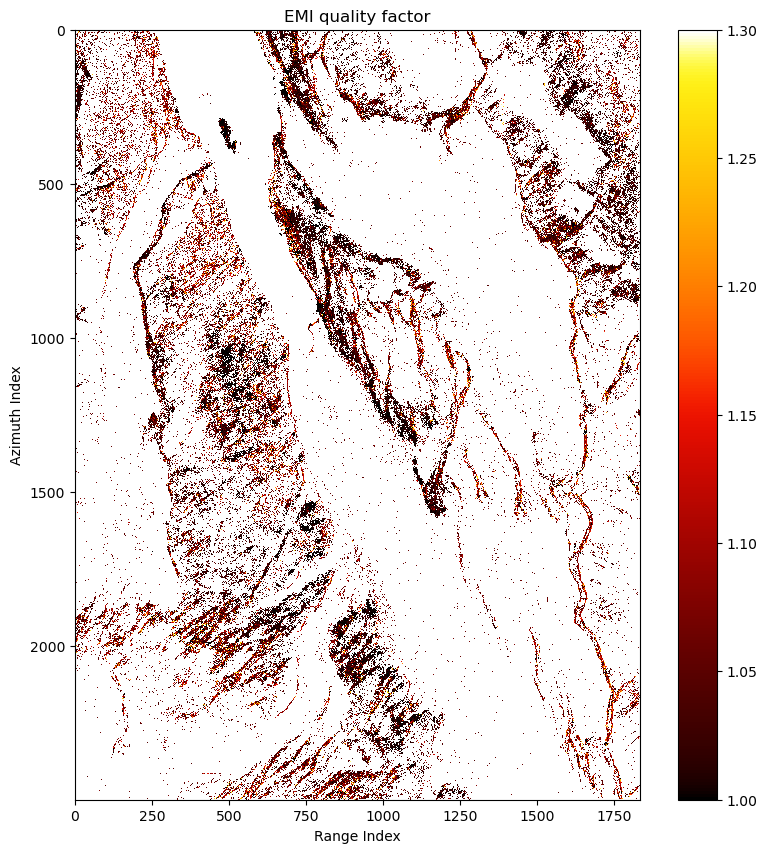

In [ ]:
emi_zarr = zarr.open('./pl/emi_quality.zarr',mode='r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(emi_zarr[:],interpolation='nearest',vmin=1.0,vmax=1.3,cmap=colorcet.cm.fire)
ax.set(title='EMI quality factor',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
plt.show()

In [ ]:
#| export
@mc_logger
def ds_temp_coh(
    coh:str, # coherence matrix
    ph:str, # wrapped phase
    t_coh:str=None, # output, temporal coherence
    tnet:str=None, # temporal network
    chunks:int=None, # point cloud chunk size, same as coh by default
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''DS temporal coherence.
    '''
    coh_path = coh
    ph_path = ph
    t_coh_path = t_coh

    logger = logging.getLogger(__name__)
    coh_zarr = zarr.open(coh_path,mode='r'); logger.zarr_info(coh_path,coh_zarr)
    ph_zarr = zarr.open(ph_path,mode='r'); logger.zarr_info(ph_path,ph_zarr)
    nimage = ph_zarr.shape[-1]

    if chunks is None: chunks = coh_zarr.chunks[0] 
    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np
        
    if tnet is not None:
        tnet = mr.TempNet.load(tnet)
    else:
        tnet = mr.TempNet.from_bandwidth(nimage)
    image_pairs = tnet.image_pairs
    
    logger.info('starting dask local cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask local cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)

        cpu_coh = dask_from_zarr(coh_path,chunks=(chunks,*coh_zarr.shape[1:]))
        logger.darr_info('coh', cpu_coh)
        
        cpu_ph = dask_from_zarr(ph_path,chunks=(chunks,*ph_zarr.shape[1:]))
        logger.darr_info('ph', cpu_ph)

        logger.info(f'Estimate temporal coherence for DS.')
        if cuda:
            coh = cpu_coh.map_blocks(cp.asarray)
            ph = cpu_ph.map_blocks(cp.asarray)
        else:
            coh = cpu_coh
            ph = cpu_ph

        coh_delayed = coh.to_delayed()
        coh_delayed = np.squeeze(coh_delayed,axis=-1)
        ph_delayed = ph.to_delayed()
        ph_delayed = np.squeeze(ph_delayed,axis=-1)
        t_coh_delayed = np.empty_like(coh_delayed,dtype=object)
        ds_temp_coh_delayed = delayed(mr.ds_temp_coh,pure=True,nout=1)

        with np.nditer(coh_delayed,flags=['multi_index','refs_ok'], op_flags=['readwrite']) as it:
            for block in it:
                idx = it.multi_index
                t_coh_delayed[idx] = ds_temp_coh_delayed(coh_delayed[idx],ph_delayed[idx],image_pairs=image_pairs)
                t_coh_delayed[idx] = da.from_delayed(t_coh_delayed[idx],shape=coh.blocks[idx].shape[0:1],meta=xp.array((),dtype=xp.float32))

            t_coh = da.block(t_coh_delayed.tolist())
    
        if cuda:
            cpu_t_coh = t_coh.map_blocks(cp.asnumpy)
        else:
            cpu_t_coh = t_coh
        logger.info(f'got temporal coherence t_coh.')
        logger.darr_info('t_coh', t_coh)

        logger.info('saving t_coh.')
        _cpu_t_coh = cpu_t_coh.to_zarr(t_coh_path,compute=False,overwrite=True)

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(_cpu_t_coh)
        progress(futures,notebook=False); time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

This function estimate the temporal coherence of DSs which is defined as [@ferrettiNewAlgorithmProcessing2011]:

$$\gamma = \frac{1}{N^2-N} \sum_{n=1}^{N} \sum_{k \neq n}^{N} e^{i\phi_{nk}} e^{-i(\theta_n-\theta_k)}$$

Where $\phi_{nk}$ is the phase of complex coherence matrix and $\theta_{n}$ is the phase after phase linking.

In [ ]:
ds_can_coh = './co/ds_can_coh.zarr'
ds_can_ph = './pl/ds_can_ph.zarr'
ds_can_t_coh = './pl/ds_can_t_coh.zarr'

In [ ]:
ds_temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh)
if is_cuda_available():
    ds_temp_coh(ds_can_coh,ds_can_ph, ds_can_t_coh,cuda=True)

2025-09-18 12:47:20 - log_args - INFO - running function: ds_temp_coh
2025-09-18 12:47:20 - log_args - INFO - fetching args:
2025-09-18 12:47:20 - log_args - INFO - coh = './co/ds_can_coh.zarr'
2025-09-18 12:47:20 - log_args - INFO - ph = './pl/ds_can_ph.zarr'
2025-09-18 12:47:20 - log_args - INFO - t_coh = './pl/ds_can_t_coh.zarr'
2025-09-18 12:47:20 - log_args - INFO - tnet = None
2025-09-18 12:47:20 - log_args - INFO - chunks = None
2025-09-18 12:47:20 - log_args - INFO - cuda = False
2025-09-18 12:47:20 - log_args - INFO - processes = None
2025-09-18 12:47:20 - log_args - INFO - n_workers = None
2025-09-18 12:47:20 - log_args - INFO - threads_per_worker = None
2025-09-18 12:47:20 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12:47:20 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:47:20 - log_args - INFO - fetching args done.
2025-09-18 12:47:20 - zarr_info - INFO - ./co/ds_can_coh.zarr zarray shape, chunks, dtype: (732727, 136), (100000, 1), complex64
2025-09-18 12:47

2025-09-18 12:47:24,822 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure
2025-09-18 12:47:24,851 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:47:26 - ds_temp_coh - INFO - computing finished. 1.7s
2025-09-18 12:47:27 - ds_temp_coh - INFO - dask cluster closed.


In [ ]:
ds_can_gix = './shp/ds_can_gix.zarr'
t_coh = './pl/t_coh.zarr'
rslc_zarr = zarr.open('./raw/rslc.zarr/',mode='r')
mc.pc2ras(ds_can_gix, ds_can_t_coh,t_coh,rslc_zarr.shape[:2])

2025-09-18 12:47:27 - log_args - INFO - running function: pc2ras
2025-09-18 12:47:27 - log_args - INFO - fetching args:
2025-09-18 12:47:27 - log_args - INFO - idx = './shp/ds_can_gix.zarr'
2025-09-18 12:47:27 - log_args - INFO - pc = './pl/ds_can_t_coh.zarr'
2025-09-18 12:47:27 - log_args - INFO - ras = './pl/t_coh.zarr'
2025-09-18 12:47:27 - log_args - INFO - shape = (2500, 1834)
2025-09-18 12:47:27 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:47:27 - log_args - INFO - processes = False
2025-09-18 12:47:27 - log_args - INFO - n_workers = 1
2025-09-18 12:47:27 - log_args - INFO - threads_per_worker = 1
2025-09-18 12:47:27 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:47:27 - log_args - INFO - fetching args done.
2025-09-18 12:47:27 - zarr_info - INFO - ./shp/ds_can_gix.zarr zarray shape, chunks, dtype: (732727, 2), (100000, 1), int32
2025-09-18 12:47:27 - pc2ras - INFO - loading gix into memory.
2025-09-18 12:47:27 - pc2ras - INFO - starting dask local cluster.
20

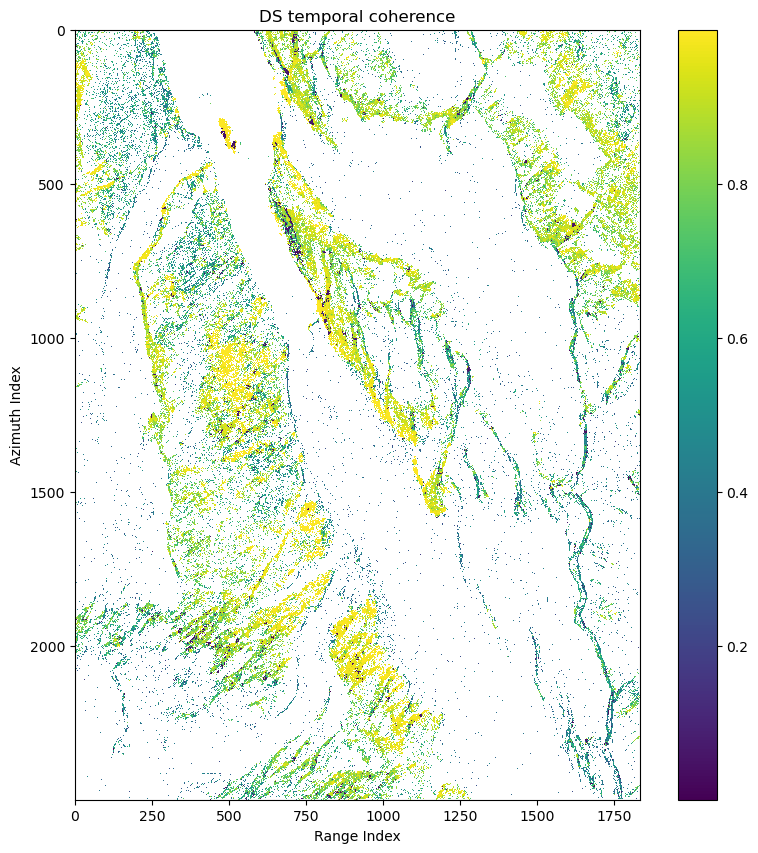

In [ ]:
t_coh_zarr = zarr.open(t_coh,mode='r')
fig, ax = plt.subplots(1,1,figsize=(10,10))
pcm = ax.imshow(t_coh_zarr[:],interpolation='nearest')
ax.set(title='DS temporal coherence',xlabel='Range Index',ylabel='Azimuth Index')
fig.colorbar(pcm)
plt.show()

In [ ]:
#| export
@mc_logger
def emperical_co_emi_temp_coh_pc(
    rslc:str, # input: rslc stack, shape (nlines, width, nimages)
    is_shp_dir:str, # input: directory for bool array indicating the SHPs of pc
    gix:str, # input: bool array indicating pc, shape (2, n_points)
    ph_dir:str, # output: directory that hold complex coherence matrix for pc
    emi_quality_dir:str, # output: directory that hold emi quality
    t_coh_dir:str, # output: directory that hold temporal coherence
    batch_size:int=1000, # input, batch size
    chunks:int=None, # parallel processing azimuth/range chunk size, optional. Default: rslc.chunks[:2]
    cuda:bool=False, # if use cuda for processing, false by default
    processes=None, # use process for dask worker over thread, the default is False for cpu, only applied if cuda==False
    n_workers=None, # number of dask worker, the default is 1 for cpu, number of GPU for cuda
    threads_per_worker=None, # number of threads per dask worker, the default is 2 for cpu, only applied if cuda==False
    rmm_pool_size=0.9, # set the rmm pool size, only applied when cuda==True
    **dask_cluster_arg, # other dask local/cudalocal cluster args
):
    '''estimating emperical coherence matrix, phase linking and estimating temporal coherence on point cloud data.
    '''
    rslc_path = rslc
    is_shp_dir_path = Path(is_shp_dir)
    gix_path = gix
    ph_dir = Path(ph_dir); mk_clean_dir(ph_dir)
    emi_quality_dir = Path(emi_quality_dir); mk_clean_dir(emi_quality_dir)
    t_coh_dir = Path(t_coh_dir); mk_clean_dir(t_coh_dir)

    logger = logging.getLogger(__name__)

    rslc_zarr = zarr.open(rslc_path,mode='r')
    logger.zarr_info(rslc_path, rslc_zarr)
    assert rslc_zarr.ndim == 3, "rslc dimentation is not 3."
    nlines, width, nimage = rslc_zarr.shape
    if chunks is None: chunks = rslc_zarr.chunks[:2]

    is_shp0 = sorted(is_shp_dir_path.glob('*.zarr'))[0]
    is_shp0_zarr = zarr.open(is_shp0,mode='r')
    az_win, r_win = is_shp0_zarr.shape[1:]
    az_half_win = int((az_win-1)/2)
    r_half_win = int((r_win-1)/2)
    logger.info(f'''azimuth window size and half azimuth window size: {az_win}, {az_half_win}''')
    logger.info(f'''range window size and half range window size: {r_win}, {r_half_win}''')

    az_chunk, r_chunk = chunks
    n_az_chunk = math.ceil(nlines/az_chunk)
    n_r_chunk = math.ceil(width/r_chunk)
    logger.info(f'parallel processing azimuth chunk size: {az_chunk}')
    logger.info(f'parallel processing range chunk size: {r_chunk}')

    depth = [az_half_win, r_half_win, 0]; boundary = {0:'none',1:'none',2:'none'}
    gix_zarr = zarr.open(gix_path,mode='r')
    logger.zarr_info(gix_path, gix_zarr)
    assert gix_zarr.ndim == 2, "gix dimentation is not 2."
    logger.info('loading gix into memory.')
    gix = mc.parallel_read_zarr(gix_zarr,(slice(None),slice(None)))
    logger.info('convert gix to the order of ras chunk')
    chunk_idx, chunk_bounds = mr.pc._pc_split_by_chunk(gix,chunks,(nlines,width))[:2]
    pc_chunksize = tuple(np.diff(chunk_bounds))
    sorted_gix = gix[chunk_idx]
    ras_chunk_order_gix = mr.pc._gix_ras_chunk(sorted_gix,chunk_bounds, chunks, (nlines,width),overlap=(az_half_win,r_half_win))

    if cuda:
        Cluster = LocalCUDACluster; cluster_args= {
            'n_workers':n_workers,
            'rmm_pool_size':rmm_pool_size}
        cluster_args.update(dask_cluster_arg)
        xp = cp
    else:
        if processes is None: processes = False
        if n_workers is None: n_workers = 1
        if threads_per_worker is None: threads_per_worker = 2
        Cluster = LocalCluster; cluster_args = {'processes':processes, 'n_workers':n_workers, 'threads_per_worker':threads_per_worker}
        cluster_args.update(dask_cluster_arg)
        xp = np
    
    logger.info('starting dask cluster.')
    with Cluster(**cluster_args) as cluster, Client(cluster) as client:
        logger.info('dask cluster started.')
        logger.dask_cluster_info(cluster)
        if cuda: client.run(cp.cuda.set_allocator, rmm_cupy_allocator)
        emperical_co_emi_temp_coh_pc_delayed = delayed(mr.emperical_co_emi_temp_coh_pc,pure=True,nout=3)

        cpu_rslc_overlap = dask_from_zarr_overlap(rslc_path, (*chunks, rslc_zarr.shape[2]), depth)
        logger.darr_info('rslc_overlap', cpu_rslc_overlap)
        cpu_gix_darr = da.from_array(ras_chunk_order_gix,chunks=(pc_chunksize,(2,)))
        logger.darr_info('gix in ras chunk order', cpu_gix_darr)
        if cuda:
            rslc_overlap = cpu_rslc_overlap.map_blocks(cp.asarray)
            gix_darr = cpu_gix_darr.map_blocks(cp.asarray)
        else:
            rslc_overlap = cpu_rslc_overlap
            gix_darr = cpu_gix_darr
        rslc_overlap_delayed = rslc_overlap.to_delayed().reshape(-1)
        gix_delayed = gix_darr.to_delayed().reshape(-1)

        logger.info(f'estimating coherence matrix chunk by chunk.')
        futures = []
        for j in range(n_az_chunk*n_r_chunk):
            do_log = j%math.ceil(n_az_chunk*n_r_chunk/10) == 0
            if pc_chunksize[j] > 0:
                cpu_is_shp = mc.dask_from_zarr(is_shp_dir_path/f'{j}.zarr',chunks=(-1,-1,-1))
                if do_log: logger.darr_info(f'is_shp for chunk {j}',cpu_is_shp)
                if cuda:
                    is_shp = cpu_is_shp.map_blocks(cp.asarray)
                else:
                    is_shp = cpu_is_shp
                is_shp_delayed = is_shp.to_delayed()[0,0,0]
                ph_delayed, emi_quality_delayed, t_coh_delayed = emperical_co_emi_temp_coh_pc_delayed(rslc_overlap_delayed[j],gix_delayed[j],is_shp_delayed,batch_size=batch_size)

                ph = da.from_delayed(ph_delayed,shape=(pc_chunksize[j],nimage),meta=xp.array((),dtype=rslc_overlap.dtype))
                emi_quality = da.from_delayed(emi_quality_delayed,shape=(pc_chunksize[j],),meta=xp.array((),dtype=xp.float32))
                t_coh = da.from_delayed(t_coh_delayed,shape=(pc_chunksize[j],),meta=xp.array((),dtype=xp.float32))

                if cuda:
                    cpu_ph = ph.map_blocks(cp.asnumpy)
                    cpu_emi_quality = emi_quality.map_blocks(cp.asnumpy)
                    cpu_t_coh = t_coh.map_blocks(cp.asnumpy)
                else:
                    cpu_ph = ph
                    cpu_emi_quality = emi_quality
                    cpu_t_coh = t_coh

                if do_log:
                    logger.darr_info(f'ph for chunk {j}',cpu_ph)
                    logger.darr_info(f'emi_quality for chunk {j}',cpu_emi_quality)
                    logger.darr_info(f't_coh for chunk {j}',cpu_t_coh)
                    logger.info(f'saving ph, emi_quality, t_coh for chunk {j}')

                _ph = dask_to_zarr(cpu_ph,ph_dir/f'{j}.zarr',chunks=(cpu_ph.shape[0],1),log_zarr=do_log)
                _emi_quality = dask_to_zarr(cpu_emi_quality,emi_quality_dir/f'{j}.zarr',chunks=(cpu_emi_quality.shape[0],),log_zarr=do_log)
                _t_coh = dask_to_zarr(cpu_t_coh,t_coh_dir/f'{j}.zarr',chunks=(cpu_t_coh.shape[0],),log_zarr=do_log)

                futures.extend((_ph,_emi_quality,_t_coh))

        logger.info('computing graph setted. doing all the computing.')
        futures = client.persist(futures)
        progress(futures,notebook=False)
        time.sleep(0.1)
        da.compute(futures)
        logger.info('computing finished.')
    logger.info('dask cluster closed.')

In [ ]:
rslc = './raw/rslc.zarr/'
ds_can_is_shp_dir = './co/ds_can_is_shp/'
ds_can_ph_dir = './pl/ds_can_ph'
ds_can_emi_quality_dir = './pl/ds_can_emi_quality'
ds_can_t_coh_dir = './pl/ds_can_t_coh'

In [ ]:
%%time
emperical_co_emi_temp_coh_pc(rslc,ds_can_is_shp_dir,ds_can_gix,ds_can_ph_dir,ds_can_emi_quality_dir,ds_can_t_coh_dir,chunks=(1000,1000))

2025-09-18 12:48:07 - log_args - INFO - running function: emperical_co_emi_temp_coh_pc
2025-09-18 12:48:07 - log_args - INFO - fetching args:
2025-09-18 12:48:07 - log_args - INFO - rslc = './raw/rslc.zarr/'
2025-09-18 12:48:07 - log_args - INFO - is_shp_dir = './co/ds_can_is_shp/'
2025-09-18 12:48:07 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-09-18 12:48:07 - log_args - INFO - ph_dir = './pl/ds_can_ph'
2025-09-18 12:48:07 - log_args - INFO - emi_quality_dir = './pl/ds_can_emi_quality'
2025-09-18 12:48:07 - log_args - INFO - t_coh_dir = './pl/ds_can_t_coh'
2025-09-18 12:48:07 - log_args - INFO - batch_size = 1000
2025-09-18 12:48:07 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:48:07 - log_args - INFO - cuda = False
2025-09-18 12:48:07 - log_args - INFO - processes = None
2025-09-18 12:48:07 - log_args - INFO - n_workers = None
2025-09-18 12:48:07 - log_args - INFO - threads_per_worker = None
2025-09-18 12:48:07 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 1

In [ ]:
if is_cuda_available():
    emperical_co_emi_temp_coh_pc(rslc,ds_can_is_shp_dir,ds_can_gix,ds_can_ph_dir,ds_can_emi_quality_dir,ds_can_t_coh_dir,chunks=(1000,1000),cuda=True)

2025-09-18 12:48:24 - log_args - INFO - running function: emperical_co_emi_temp_coh_pc
2025-09-18 12:48:24 - log_args - INFO - fetching args:
2025-09-18 12:48:24 - log_args - INFO - rslc = './raw/rslc.zarr/'
2025-09-18 12:48:24 - log_args - INFO - is_shp_dir = './co/ds_can_is_shp/'
2025-09-18 12:48:24 - log_args - INFO - gix = './shp/ds_can_gix.zarr'
2025-09-18 12:48:24 - log_args - INFO - ph_dir = './pl/ds_can_ph'
2025-09-18 12:48:24 - log_args - INFO - emi_quality_dir = './pl/ds_can_emi_quality'
2025-09-18 12:48:24 - log_args - INFO - t_coh_dir = './pl/ds_can_t_coh'
2025-09-18 12:48:24 - log_args - INFO - batch_size = 1000
2025-09-18 12:48:24 - log_args - INFO - chunks = (1000, 1000)
2025-09-18 12:48:24 - log_args - INFO - cuda = True
2025-09-18 12:48:24 - log_args - INFO - processes = None
2025-09-18 12:48:24 - log_args - INFO - n_workers = None
2025-09-18 12:48:24 - log_args - INFO - threads_per_worker = None
2025-09-18 12:48:24 - log_args - INFO - rmm_pool_size = 0.9
2025-09-18 12

2025-09-18 12:48:26,875 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure
2025-09-18 12:48:26,875 - distributed.worker - WARNING - Setting CPU affinity for GPU failed. Please refer to the following link for troubleshooting information: https://docs.rapids.ai/api/dask-cuda/nightly/troubleshooting/#setting-cpu-affinity-failure


2025-09-18 12:48:27 - emperical_co_emi_temp_coh_pc - INFO - dask cluster started.
2025-09-18 12:48:27 - dask_cluster_info - INFO - dask cluster: LocalCUDACluster(dashboard_link='http://127.0.0.1:8787/status', workers=2, threads=2, memory=256.00 GiB)
2025-09-18 12:48:27 - darr_info - INFO - rslc_overlap dask array shape, chunksize, dtype: (2520, 1844, 17), (1010, 1005, 17), complex64
2025-09-18 12:48:27 - darr_info - INFO - gix in ras chunk order dask array shape, chunksize, dtype: (732727, 2), (201403, 2), int32
2025-09-18 12:48:27 - emperical_co_emi_temp_coh_pc - INFO - estimating coherence matrix chunk by chunk.
2025-09-18 12:48:27 - darr_info - INFO - is_shp for chunk 0 dask array shape, chunksize, dtype: (201097, 11, 11), (201097, 11, 11), bool
2025-09-18 12:48:27 - darr_info - INFO - ph for chunk 0 dask array shape, chunksize, dtype: (201097, 17), (201097, 17), complex64
2025-09-18 12:48:27 - darr_info - INFO - emi_quality for chunk 0 dask array shape, chunksize, dtype: (201097,),

Then concat the result:

In [ ]:
ds_can_ph_ = './pl/ds_can_ph_.zarr'
ds_can_emi_quality_ = './pl/ds_can_emi_quality_.zarr'
ds_can_t_coh_ = './pl/ds_can_t_coh_.zarr'
ds_can_key = './co/ds_can_key.zarr'

In [ ]:
chunks = zarr.open(ds_can_gix,mode='r').chunks[0]
mc.pc_concat(
    [ds_can_ph_dir,ds_can_emi_quality_dir,ds_can_t_coh_dir],
    [ds_can_ph_,ds_can_emi_quality_,ds_can_t_coh_],
    key=ds_can_key,
    chunks=chunks)

2025-09-18 12:48:39 - log_args - INFO - running function: pc_concat
2025-09-18 12:48:39 - log_args - INFO - fetching args:
2025-09-18 12:48:39 - log_args - INFO - pcs = ['./pl/ds_can_ph', './pl/ds_can_emi_quality', './pl/ds_can_t_coh']
2025-09-18 12:48:39 - log_args - INFO - pc = ['./pl/ds_can_ph_.zarr', './pl/ds_can_emi_quality_.zarr', './pl/ds_can_t_coh_.zarr']
2025-09-18 12:48:39 - log_args - INFO - key = './co/ds_can_key.zarr'
2025-09-18 12:48:39 - log_args - INFO - chunks = 100000
2025-09-18 12:48:39 - log_args - INFO - processes = False
2025-09-18 12:48:39 - log_args - INFO - n_workers = 1
2025-09-18 12:48:39 - log_args - INFO - threads_per_worker = 1
2025-09-18 12:48:39 - log_args - INFO - dask_cluster_arg = {}
2025-09-18 12:48:39 - log_args - INFO - fetching args done.
2025-09-18 12:48:39 - pc_concat - INFO - input pcs: [[Path('pl/ds_can_ph/0.zarr'), Path('pl/ds_can_ph/1.zarr'), Path('pl/ds_can_ph/2.zarr'), Path('pl/ds_can_ph/3.zarr'), Path('pl/ds_can_ph/4.zarr'), Path('pl/ds_c

In [ ]:
#| hide
np.testing.assert_array_equal(zarr.open('./pl/ds_can_ph_.zarr',mode='r')[:],zarr.open('./pl/ds_can_ph.zarr/',mode='r')[:])
np.testing.assert_array_equal(zarr.open('./pl/ds_can_emi_quality_.zarr',mode='r')[:],zarr.open('./pl/ds_can_emi_quality.zarr/',mode='r')[:])
np.testing.assert_array_equal(zarr.open('./pl/ds_can_t_coh_.zarr',mode='r')[:],zarr.open('./pl/ds_can_t_coh.zarr/',mode='r')[:])

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()